<h1>Exploring the Validation script output</h1>

This notebook describes how to load and explore the validation script output. The validation script is very complete and generic, so understanding it requires a few minutes.

*you will need to change this path below: <code>path_to_yaml_output_files</code>

In [11]:
import yaml
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import glob

path_to_yaml_output_files = '/home/carnero/Dropbox/DES_photoz_wg/project38/nz_codes/train_1_noweight/valid_1_noweight/'

Some plotting settings

In [12]:
almost_black = '#262626'
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams.update({'font.size': 32, 
                     'axes.linewidth': 5,
                    'text.color': almost_black,
                    'xtick.major.size': 4,
                    'ytick.major.size': 4,
                    'legend.fancybox': True,
                    'figure.dpi': 300,
                    'legend.fontsize': 16,
                    'legend.framealpha': 0.8,
                    'legend.shadow': True,
                    'xtick.labelsize': 22,
                    'ytick.labelsize': 22})

In [13]:
#path to your own files, or directory with many .yaml files
#files = ['/Users/hoyleb/Documents/python/modules/photoz-wg/validation/point_.yaml']
files = glob.glob(path_to_yaml_output_files + '*.yaml')
assert len(files) > 0,'Check the file path'

<h4>Results on redshift scaled residuals</h4>
If you want to see the redshift residulas result, change 'diff_1pz' to diff below.

The below assumes we have one fits file per point prediction file. If this is different, then you will need to perform another loop over "pointFileName" below.

This data is complex, so let's extract the data we need. We'll store it in "arr"

In [14]:
#load in the yaml files, and extract some items of interest
arr = {}
for k, f1 in enumerate(files):
    res = yaml.load(open(f1, 'r'))
    codeName =  f1.split('/')[-1].split('point_')[1].split('.yaml')[0]
    pointFileName = res.keys()
    #loop here if more than one point file per yaml file
    fileN =  pointFileName[0].split('/')[-1].split('.fits')[0]
    resF = res[pointFileName[0]]
    testName = resF.keys()
    tsts = resF[testName[0]]

    pps = tsts.keys()
    metrics  = tsts[pps[0]].keys()
    
    #make an array to hold the output
    arr[codeName] = np.zeros((len(metrics), len(pps), 2))

    for i, metric in enumerate(metrics):
        for j, z_type in enumerate(pps):
            arr[codeName][i, j, :] = tsts[z_type][metric]['diff_1pz']['MEAN_bootstrap_mean_error'], tsts[z_type][metric]['diff_1pz']['SIGMA_bootstrap_mean_error']
            #arr[codeName][i, j, :] = tsts[z_type][metric]['delta_z']['MEAN_bootstrap_mean_error'], tsts[z_type][metric]['delta_z']['SIGMA_bootstrap_mean_error']

<h4>Plot time!</h4>
Now we've extracted the required info, let's make some plots. Adjust the plot settings above, to change the global layout of the plots

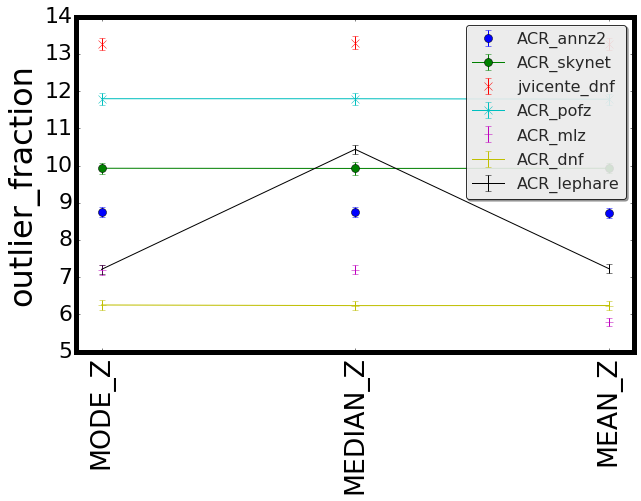

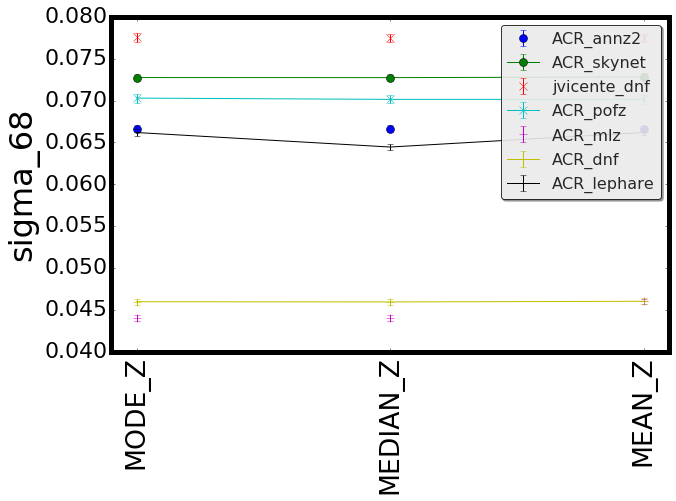

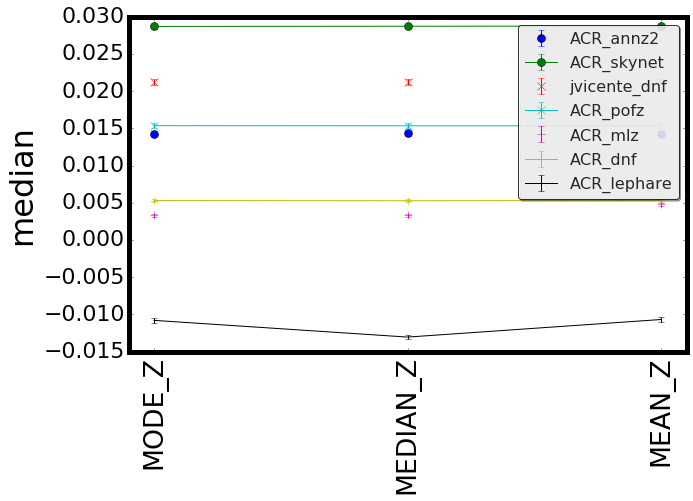

In [15]:
fmt_ = {}
poss_fmt = ['o', '-o', 'x', '-x', '+', '-+', '-', '--', '.', '-.']
for i, codeName in enumerate(arr.keys()):
    fmt_[codeName] = poss_fmt[i]

#make some plots:
for i, metric in enumerate(metrics):
    fig = plt.figure()
    for codeName in arr.keys():
        rng = range(len(arr[codeName][i, :, 0]))
        plt.errorbar(rng, arr[codeName][i, :, 0], yerr=arr[codeName][i, :, 1], fmt=fmt_[codeName], label=codeName, markersize=8)
    plt.ylabel(metric.split('.')[-1])
    plt.legend(numpoints=1)
    plt.xlim(-0.1,len(rng)-1+0.1)
    plt.xticks(rng, tsts.keys(), size='small', rotation=90)

<h3>Plots as a function of redshift</h3>
We have also calculated plots as a function of "median_z" redshift in bins defined in the yaml files in /validation/testConfigs

In [16]:
#load in the yaml files, and extract some items of interest
arr_bn = {}


for k, f1 in enumerate(files):
    res = yaml.load(open(f1, 'r'))
    codeName =  f1.split('/')[-1].split('point_')[1].split('.yaml')[0]
    filename = res.keys()
    fileN =  filename[0].split('/')[-1].split('.fits')[0]
    resF = res[filename[0]]

    testName = resF.keys()
    tsts = resF[testName[0]]

    pps = tsts.keys()
    metrics  = tsts[pps[0]].keys()
    
    #make an array to hold the output
    arr_bn[codeName] = {}
    
    for i, metric in enumerate(metrics):
        for j, z_type in enumerate(pps):
            bin_key =  tsts[z_type][metric]['diff_1pz']['bins'].keys()
            
            #let's just extraact the first bin key, in we have more make a loop here
            bin_key = bin_key[0]
            
            if bin_key not in arr_bn[codeName]:
                bin_centers = tsts[z_type][metric]['diff_1pz']['bins'][bin_key]['BIN_CENTERS']
                arr_bn[codeName][bin_key] = np.zeros((len(metrics), len(pps), 3, len(bin_centers)))
        
            arr_bn[codeName][bin_key][i, j, 0, :] = np.array(tsts[z_type][metric]['diff_1pz']['bins'][bin_key]['BIN_CENTERS'])
            arr_bn[codeName][bin_key][i, j, 1, :] = tsts[z_type][metric]['diff_1pz']['bins'][bin_key]['MEAN_BS']
            arr_bn[codeName][bin_key][i, j, 2, :] = tsts[z_type][metric]['diff_1pz']['bins'][bin_key]['SIGMA_BS']
            

<h3>Plots of binned point predictions</h3>

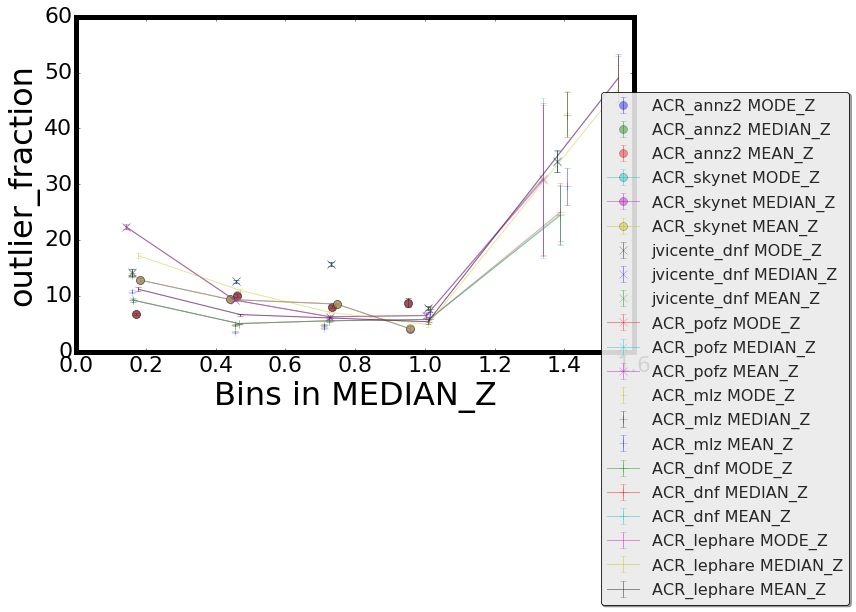

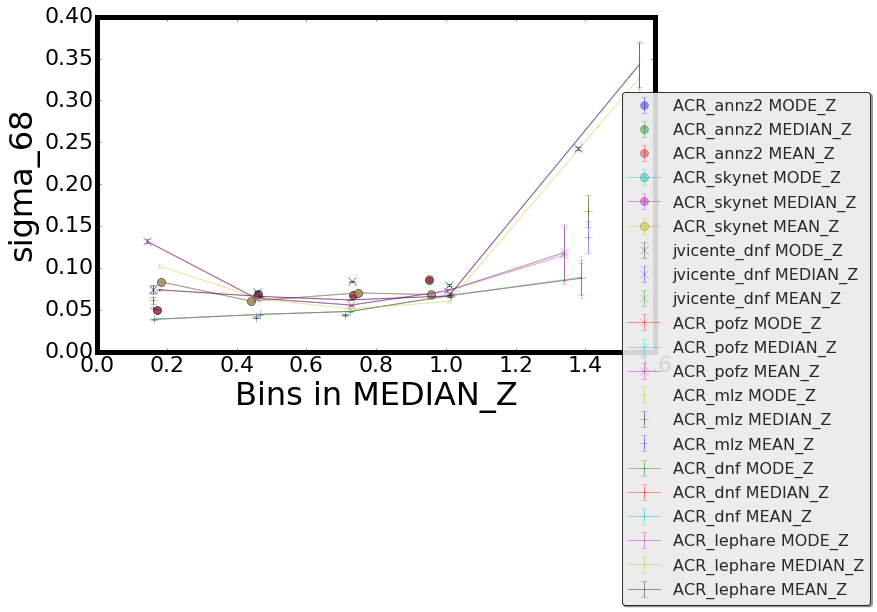

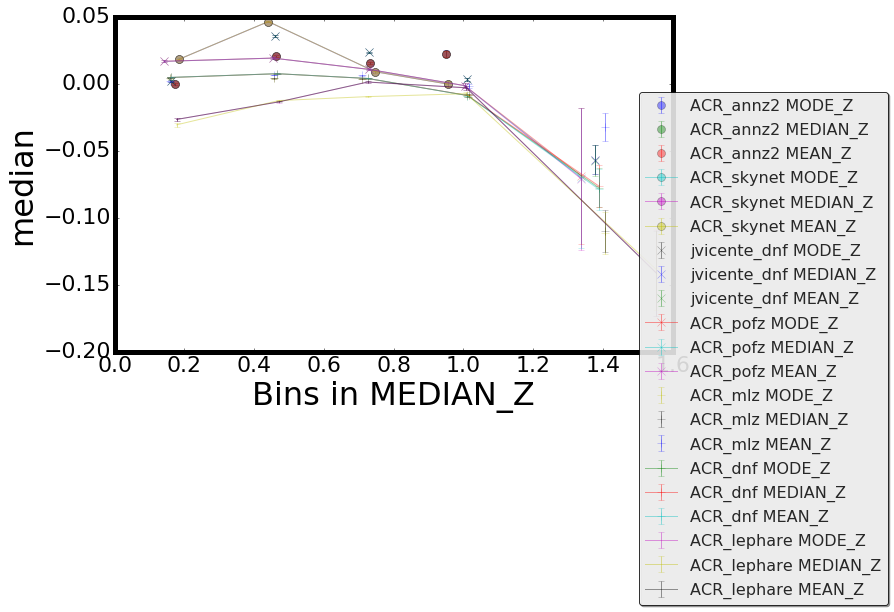

In [17]:
#make some plots:
for i, metric in enumerate(metrics):
    fig = plt.figure()
    for codeName in arr.keys():
        for j, z_type in enumerate(pps):
            for bin_key in arr_bn[codeName]:
    
                plt.errorbar(arr_bn[codeName][bin_key][i, j, 0, :], arr_bn[codeName][bin_key][i, j, 1, :], 
                             yerr=arr_bn[codeName][bin_key][i, j, 2, :], fmt=fmt_[codeName] , alpha=0.4,
                             label=codeName + ' ' + z_type, markersize=8)
    plt.ylabel(metric.split('.')[-1])
    plt.xlabel('Bins in ' + bin_key)
    plt.legend(numpoints=1,bbox_to_anchor=(1.4, .8))
    

<h2>Pdf metrics</h2>
Currently we don't have strong requirements on pdf metrics. We start by reading in the pdf_.yaml files.

In [11]:
#path to your own files, or directory with many .yaml files
#files = ['/photoz-wg/validation/pdf_.yaml'] or 
files = glob.glob(path_to_yaml_output_files + 'pdf*.yaml')

We need to load in the files again, and loop over 1) the test name, 2) the metric name and then print the metric values

In [14]:
for k, f1 in enumerate(files):
    res = yaml.load(open(f1, 'r'))
    codeName =  f1.split('/')[-1].split('pdf_')[1].split('.yaml')[0]
    pdfFileName = res.keys()
    pdfFileName = pdfFileName[0]
    pdfFlNm = pdfFileName.split('/')[-1]
    print " "
    print 'hdf5 file name: ' + pdfFlNm
    for testName in res[pdfFileName].keys():
        for metricName in res[pdfFileName][testName]:
            mn = metricName.split('.')[1]
            print mn, res[pdfFileName][testName][metricName]['VALUE']

 
hdf5 file name: Y1A1_GOLD101_Y1A1trainValid_14.12.2015.validsY1A1.25215.out.DES.pdf.hdf5
log_loss 1.46902917648
ks_test 0.156
npoisson 4416809.39306
 
hdf5 file name: TestData_validHDF.hdf5
log_loss 2.49627936935
ks_test 0.07
npoisson 0.0912641394015


<h3>Want other plots?</h3>
Remeber you have acces to all the values in the yaml file. Take a look at the raw file, it's human readable, and also a dictiony when read in using <code>yaml.load('filename.yaml')</code>

In [11]:
print res

{'../../../../Dropbox/DES_photoz_wg/project38/nz_codes/train_1_noweight/valid_1_noweight/train_1_nw_valid_1_nw_dnf_acr.fits': {'test_CS2O5': {'MODE_Z': {'bh_photo_z_validation.outlier_fraction': {'diff_1pz': {'MEAN_bootstrap_mean_error': 6.254971077368041, 'VALUE': 6.245480838756326, 'bins': {'MEDIAN_Z': {'SIGMA_BS': [0.27244981934967377, 0.1615368337053154, 0.20147855971164977, 0.40846292554236463, 5.271274048863359], 'BIN_CENTERS_SIGMA_BS': [0.0007550838461791872, 0.000598359905378464, 0.0007550179338207041, 0.0014177019532170014, 0.010013446564315576], 'MEAN_BS': [9.230308625440166, 5.019211504150235, 5.528870268455937, 5.760745045511963, 24.41247930539678], 'BIN_CENTERS_MEAN_BS': [0.1616468617354635, 0.4669010718704865, 0.7259751876795836, 1.0118660604045175, 1.3890188548176283], 'VALUE': [9.229239184485332, 5.015124980098711, 5.51980198019802, 5.752636625119846, 24.65753424657534], 'BIN_CENTERS': [0.16163425268349912, 0.4668756558834703, 0.7259919571236804, 1.0118769201157187, 1.3